In [ ]:
!pip install jpype1==0.7.0
!pip install konlpy


     |████████████████████████████████| 2.7MB 5.2MB/s 
     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import konlpy
from konlpy.tag import Okt
from konlpy.tag import Kkma
import re

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def cosim(x,y):
    denom = norm(x)* norm(y)
    if denom==0:
        return 0
    return np.dot(x,y.T)/(norm(x)* norm(y))

def nuclear_norm(x,y):
    return np.sum(np.abs(x-y))

def spectral_norm(x,y):
    return np.max(np.abs(x-y))

def l2_norm(x,y):
    return np.sqrt(np.sum((x-y)**2))

def rbf_kernel(x,y):
    return np.exp(-1/2*(np.sum((x-y)**2)))

def most_similar(X, x, n, method="cosine"):
    if method=="cosine":
        lst = [(cosim(X[x, :], X[i,:]), i) for i in range(len(X))]
        lst.sort(reverse=True)
    if method=="nuclear":
        lst = [(nuclear_norm(X[x, :], X[i,:]), i) for i in range(len(X))]
        lst.sort(reverse=False)
    if method=="spectral":
        lst = [(spectral_norm(X[x, :], X[i,:]), i) for i in range(len(X))]
        lst.sort(reverse=False)
    if method=="l2":
        lst = [(l2_norm(X[x, :], X[i,:]), i) for i in range(len(X))]
        lst.sort(reverse=False)    
    if method=="rbf":
        lst = [(rbf_kernel(X[x, :], X[i,:]), i) for i in range(len(X))]
        lst.sort(reverse=False)    
    return lst[:n]


# Korean 

okt = Okt()
kkma = Kkma()
def trim_ko(x):
    
    text=re.sub("[(<.*?>)/'…“”']"," ",x)
    #text=re.sub("(\\W|\\d)"," ",text)
    
    #text = kkma.sentences(text)
    #print(text)
    text = " ".join([w[0] for w in okt.pos(text) if w[1]=="Noun" or w[1]=='Verb' or w[1]=="Adjective"])
    #textx= " ".join([w[0] for w in kkma.pos(text) if w[1]=='NNG' or w[1]=='VA' or w[1]=="MAG"  or w[1]=='MAC'])

    #remove whitespace
    text=text.strip()
    return text


# Story To PCA

In [ ]:
df = pd.read_excel("/content/drive/My Drive/Data/1970_2019_영화전체.xlsx")
df.스토리_ko.fillna("", inplace=True)
df.스토리_ko = df.스토리_ko.astype(str)
df.genres = df.genres.astype(str)

df.스토리_ko = df.스토리_ko.apply(lambda x:x.replace("\n"," "))
df.스토리_ko = df.스토리_ko.progress_apply(trim_ko)

In [ ]:
corpus = df.스토리_ko[(df.스토리_ko.notnull()) & (df.스토리_ko.apply(lambda x: True if len(x)>3 else False))]
corpus = corpus.reset_index()
corpus.head()

,index,스토리_ko
0,0,줄거리 내 생각 들린다고 자신 개발 텔레파시 장치 통해 강아지 헨리 의 생각 읽을 ...
1,3,줄거리 인류 위협 하는 공룡 맞서 싸우는 특수 대원 활약 그린 판타지 액션 영화
2,5,줄거리 월요일 아침 학교 늦은 아들 데려다 주고 출근 해야하는 레이첼 꽉 막힌 도로...
3,7,줄거리 제 차 세계대전 말기 엄마 로지 스칼렛 요한슨 와 단둘 살 있는 살 소년 조...
4,9,줄거리 당신 줄 건 한 단어 테넷 이해 하지 느껴라 시간 흐름 뒤집는 인 버전 통해...


In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(corpus.스토리_ko.values)
X = X.toarray()
X.shape

(2676, 2000)

In [ ]:
pca = PCA(n_components=5)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

new_X = pca.fit_transform(X)
new_X.shape

[0.00719843 0.00636207 0.00560346 0.00490829 0.00445288]
[4.3205935  4.06184837 3.81199981 3.56771328 3.39816956]


(2676, 5)

In [ ]:
ret = most_similar(new_X, 0, 10, method="cosine")
for i in ret:
    index = corpus.loc[i[1],'index']
    print(f" {df.loc[index, 'genres']:10s} : {df.loc[index, '스토리_ko'][:100]:}")
    #print(f"{df.loc[i[1], '스토리_ko'][:100]:}")

 코미디,드라마    : 줄거리 내 생각 들린다고 자신 개발 텔레파시 장치 통해 강아지 헨리 의 생각 읽을 수 있게 된 천재 소년 올리버 성공 대한 기쁨 잠시 가족 떨어져 살 될 위기 처 올리버 와 헨리 
 애니메이션,판타지,뮤지컬,어드벤처,가족 : 줄거리 오즈 마법사 원작 탄생 주년 기념 대작 빛 사라진 에메랄드 시티 구원 할 도로시 돌아왔다 안녕 나 캔자스 사는 도로시 해 날 마법 같은 일어났어 무지개 나를 쫓아와 어디 론
 공포(호러),스릴러 : 줄거리 기억 너머 숨어있던 거대한 진실 당신 감각 지배 할 초 현실 로 스릴러 온다 모범생 베케트 파티 광 럭키 천재 엘리엇 반항 레이브 이 네 명의 남녀 베케트 부모님 방치 해 
 애니메이션,코미디,어드벤처 : 줄거리 심심한 세상 끝났다 곧 하늘 무너지고 내 뜬다 슬슬 세상 구 해볼까 갑자기 하늘 떨어진 무언가 의해 머리 강타 치킨 리틀 하늘 무너지고 있다고 확신 고향 마을 오우 키 오크
 애니메이션,어드벤처 : 줄거리 니코 떠나는 신나는 어드벤처 가자 신비한 마법 세계 할아버지 할머니 살 있는 살 니코 친구 괴롭힘 당하다가 실수 오래된 나무 불 지르게 되고 성난 나무 니코 할아버지 할머니
 애니메이션,어드벤처,가족,판타지 : 줄거리 과자 먹으면 동물 변신 반복 되는 일상 지루해하던 오웬 신비한 과자 상자 삼촌 유품 남겨진다 세상 먹는 순간 동물 변하는 마법 과자 평생 꿈꿔 온 서커스 시작 해보기로 결심
 애니메이션,가족,어드벤처,코미디 : 줄거리 이 세상 가장 특별한 가족 온다 치즈 마을 지하 마을 사람 상상 할 존재 살 있다 그 바로 네모 반듯한 박스 입고 다니는 귀여운 몬스터 박스 트롤 박스 쓴 인간 소년 비록 
 스릴러        : 줄거리 가장 어 두운 악 깨우는 가장 빛나는 능력 샤이닝 먹어라 그 막아라 어린시절 아버지 남긴 트라우마 벗어나지 못 대니 자신 가진 샤이닝 능력 죽음 앞둔 이 돕는 닥터 슬립 불
 액션         : 줄거리 모든 히어로 능력 하나로 모였다 솔로몬 지혜 헤라클레스 힘 

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(new_X)
kmeans.labels_

array([2, 7, 9, ..., 5, 6, 1], dtype=int32)

In [ ]:
data = pd.DataFrame([corpus['index'], new_X[:,0], new_X[:,1], new_X[:,2],new_X[:,3], new_X[:,4], kmeans.labels_]).T
data.columns=['df_index','x0','x1','x2','x3','x4','label']
data.df_index = data.df_index.astype(int)
data.label = data.label.astype(int)

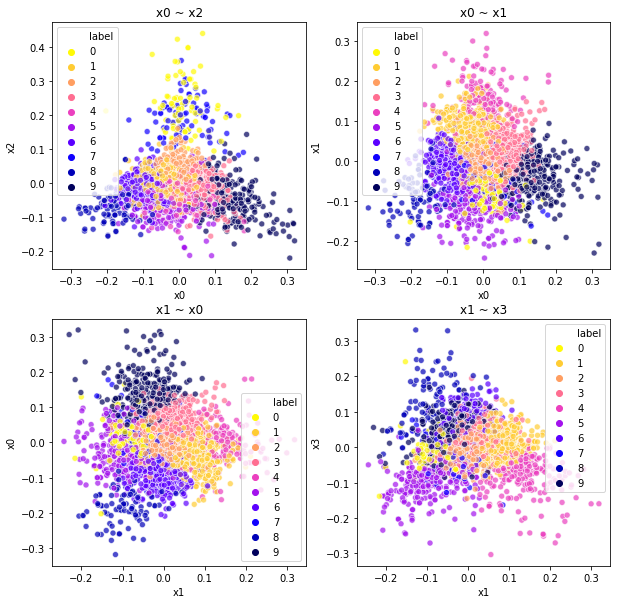

In [ ]:
f, ax = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        if i==j:
            j2 = j+2
        else:
            j2 = j
        sns.scatterplot(x='x'+str(i),y='x'+str(j2),hue='label', data=data,
                legend='full', palette=sns.color_palette("gnuplot2_r", n_colors=data.label.nunique()),
                alpha=0.7, ax =ax[i][j])
        ax[i][j].set_title("x"+str(i)+" ~ x"+str(j2))

In [ ]:
for i in tqdm(range(kmeans.cluster_centers_.shape[0])):
    data['center_angle'+str(i+1)] = 0
    for j in range(len(data)):
        data.loc[j, 'center_angle'+str(i+1)] =  cosim(kmeans.cluster_centers_[i,:], data.iloc[j, 1:kmeans.cluster_centers_.shape[1]+1].values )

In [ ]:
data

,df_index,x0,x1,x2,x3,x4,label,center_angle1,center_angle2,center_angle3,center_angle4,center_angle5,center_angle6,center_angle7,center_angle8,center_angle9,center_angle10
0,0,-0.027440,-0.046735,0.001222,-0.007726,-0.030526,2,0.459916,-0.634579,0.419405,-0.312549,-0.537552,0.628538,0.342371,-0.183696,0.529557,-0.335597
1,3,-0.139023,-0.041158,0.185709,0.056368,0.221978,7,0.115653,0.305180,0.265281,-0.743291,-0.283207,-0.140113,0.441106,0.831863,0.237650,-0.269267
2,5,0.176497,0.010671,-0.104957,0.049618,-0.072200,9,-0.197856,-0.363120,-0.412866,0.900482,-0.021829,-0.156486,-0.543537,-0.533412,-0.308606,0.766878
3,7,-0.007019,-0.076433,0.020901,-0.046120,-0.065877,2,0.653056,-0.755046,0.614338,-0.071782,-0.369635,0.623845,-0.149121,-0.088530,0.043266,-0.177011
4,9,-0.061421,-0.005673,0.011988,0.063355,0.043213,6,-0.167815,0.379185,-0.130889,-0.541992,-0.388214,-0.278352,0.865509,0.282917,0.741507,-0.270110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,5813,0.079645,0.105129,-0.008806,-0.044701,0.081031,4,-0.450038,0.492060,-0.354798,0.213064,0.674289,-0.312869,-0.574690,0.228302,-0.736761,0.315879
2672,5815,0.200239,-0.014906,-0.010474,0.087478,0.077280,9,-0.164838,-0.251193,-0.303467,0.552938,-0.278057,-0.338904,-0.523017,0.213205,-0.394525,0.944570
2673,5817,-0.053887,-0.066665,-0.000806,-0.072515,-0.010311,5,0.211638,-0.429370,0.330430,-0.647897,-0.133609,0.883245,0.137083,0.076858,0.219064,-0.442168
2674,5819,-0.060442,-0.024307,-0.000970,0.138879,-0.008729,6,0.011169,0.084262,-0.111899,-0.050660,-0.592710,-0.387972,0.791635,-0.125892,0.816460,-0.068338


In [ ]:
df_made = pd.DataFrame(index=df.index).join(data.set_index('df_index'))
df_made.fillna(0, inplace=True)
df_made

,x0,x1,x2,x3,x4,label,center_angle1,center_angle2,center_angle3,center_angle4,center_angle5,center_angle6,center_angle7,center_angle8,center_angle9,center_angle10
0,-0.027440,-0.046735,0.001222,-0.007726,-0.030526,2.0,0.459916,-0.634579,0.419405,-0.312549,-0.537552,0.628538,0.342371,-0.183696,0.529557,-0.335597
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.139023,-0.041158,0.185709,0.056368,0.221978,7.0,0.115653,0.305180,0.265281,-0.743291,-0.283207,-0.140113,0.441106,0.831863,0.237650,-0.269267
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5821,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5822,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5823,-0.043530,0.028468,0.054175,0.055816,0.007334,1.0,0.293310,0.572018,0.322213,-0.222262,-0.143784,-0.696295,0.609523,0.326104,0.360772,-0.456063


In [ ]:
df_made.to_excel("스토리수치화.xlsx", index=False)

In [ ]:
df = pd.read_excel("/content/최종일까3.xlsx")
df

,index,movienm,showtm,prdtyear,domestic,mpaa,raters,ratings,kor_revenue,kor_audience,sf,family,performance,horror,etc,documentary,drama,romance,musical,mystery,crime,history,western,adult,thriller,animation,action,adventure,war,comedy,fantasy,director_appearance,director_revenue,distributor_share,opendt_quarter,year_gap,showtypes_num,actor_score,neg,pos,neu,compound,story_com,music_com,direction_com,actor_com,acting_com,story_pos,music_pos,direction_pos,actor_pos,acting_pos,story_neg,music_neg,direction_neg,actor_neg,acting_neg
0,2,드라이브,100,2011,35061555,15,228016,7.2,156237980,D,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.168718e+07,0.0016,4,0,2,52.00,0.100,0.196,0.704,0.9999,0.512771,0.052921,0.034673,0.288320,0.111315,0.152747,0.188062,0.189990,0.164626,0.128080,0.062790,0.049102,0.054944,0.056879,0.086326
1,7,조조 래빗,108,2019,33370906,12,250206,7.9,965083200,C,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,1.161431e+08,0.0000,1,1,1,92.25,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10,존 윅 - 리로드,122,2017,92029184,18,351231,7.5,2231583601,C,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,2,3.067639e+07,0.0407,1,0,2,6.00,0.142,0.183,0.675,0.9998,0.628889,0.014945,0.013700,0.260274,0.082193,0.143124,0.184568,0.232524,0.140583,0.122165,0.096614,0.189901,0.046541,0.102961,0.142104
3,13,메멘토,113,2000,25544867,15,1096788,8.4,325278300,D,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,4,8.514956e+06,0.0020,3,1,2,32.00,0.111,0.152,0.737,0.9996,0.603444,0.000002,0.028737,0.216475,0.151341,0.127590,1.000000,0.177255,0.134459,0.125366,0.068866,1.000000,0.040797,0.068504,0.077417
4,25,존 윅: 특별판,107,2014,43037835,18,519268,7.4,81322120,D,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.434594e+07,0.0407,1,3,1,50.00,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485,5780,쿼터매인,99,1986,3751699,12,8643,4.6,147000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1.250566e+06,0.0000,1,1,1,0.00,0.170,0.148,0.682,-0.9996,0.538040,0.028987,0.043480,0.271738,0.117754,0.121259,0.190051,0.080830,0.124893,0.118967,0.123747,0.098431,0.141827,0.122979,0.112383
3486,5783,크로커다일 던디2,112,1988,109306210,15,844,3.3,39000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3.643540e+07,0.1035,2,2,1,47.50,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3487,5788,탱고와 캐쉬,100,1989,63408614,15,307534,7.5,266000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.000000e+00,0.1519,3,1,1,0.00,0.118,0.223,0.659,1.0000,0.533232,0.016250,0.033975,0.258493,0.158051,0.187390,0.260704,0.163689,0.191616,0.173335,0.090000,0.085901,0.101430,0.082965,0.100139
3488,5807,폴링 인 러브,110,1984,11129057,12,12334,6.5,4186000,D,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.709686e+06,0.1035,1,3,2,184.00,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df = df.set_index("index")
df

,movienm,showtm,prdtyear,domestic,mpaa,raters,ratings,kor_revenue,kor_audience,sf,family,performance,horror,etc,documentary,drama,romance,musical,mystery,crime,history,western,adult,thriller,animation,action,adventure,war,comedy,fantasy,director_appearance,director_revenue,distributor_share,opendt_quarter,year_gap,showtypes_num,actor_score,neg,pos,neu,compound,story_com,music_com,direction_com,actor_com,acting_com,story_pos,music_pos,direction_pos,actor_pos,acting_pos,story_neg,music_neg,direction_neg,actor_neg,acting_neg
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,드라이브,100,2011,35061555,15,228016,7.2,156237980,D,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.168718e+07,0.0016,4,0,2,52.00,0.100,0.196,0.704,0.9999,0.512771,0.052921,0.034673,0.288320,0.111315,0.152747,0.188062,0.189990,0.164626,0.128080,0.062790,0.049102,0.054944,0.056879,0.086326
7,조조 래빗,108,2019,33370906,12,250206,7.9,965083200,C,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,1.161431e+08,0.0000,1,1,1,92.25,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,존 윅 - 리로드,122,2017,92029184,18,351231,7.5,2231583601,C,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,2,3.067639e+07,0.0407,1,0,2,6.00,0.142,0.183,0.675,0.9998,0.628889,0.014945,0.013700,0.260274,0.082193,0.143124,0.184568,0.232524,0.140583,0.122165,0.096614,0.189901,0.046541,0.102961,0.142104
13,메멘토,113,2000,25544867,15,1096788,8.4,325278300,D,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,4,8.514956e+06,0.0020,3,1,2,32.00,0.111,0.152,0.737,0.9996,0.603444,0.000002,0.028737,0.216475,0.151341,0.127590,1.000000,0.177255,0.134459,0.125366,0.068866,1.000000,0.040797,0.068504,0.077417
25,존 윅: 특별판,107,2014,43037835,18,519268,7.4,81322120,D,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.434594e+07,0.0407,1,3,1,50.00,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780,쿼터매인,99,1986,3751699,12,8643,4.6,147000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1.250566e+06,0.0000,1,1,1,0.00,0.170,0.148,0.682,-0.9996,0.538040,0.028987,0.043480,0.271738,0.117754,0.121259,0.190051,0.080830,0.124893,0.118967,0.123747,0.098431,0.141827,0.122979,0.112383
5783,크로커다일 던디2,112,1988,109306210,15,844,3.3,39000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3.643540e+07,0.1035,2,2,1,47.50,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5788,탱고와 캐쉬,100,1989,63408614,15,307534,7.5,266000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.000000e+00,0.1519,3,1,1,0.00,0.118,0.223,0.659,1.0000,0.533232,0.016250,0.033975,0.258493,0.158051,0.187390,0.260704,0.163689,0.191616,0.173335,0.090000,0.085901,0.101430,0.082965,0.100139


In [ ]:
df = df.join(df_made, how='left')

In [ ]:
df = df.reset_index()
df
#df.to_excel("최종일까4.xlsx")

,index,movienm,showtm,prdtyear,domestic,mpaa,raters,ratings,kor_revenue,kor_audience,sf,family,performance,horror,etc,documentary,drama,romance,musical,mystery,crime,history,western,adult,thriller,animation,action,adventure,war,comedy,fantasy,director_appearance,director_revenue,distributor_share,opendt_quarter,year_gap,showtypes_num,actor_score,neg,pos,neu,compound,story_com,music_com,direction_com,actor_com,acting_com,story_pos,music_pos,direction_pos,actor_pos,acting_pos,story_neg,music_neg,direction_neg,actor_neg,acting_neg,x0,x1,x2,x3,x4,label,center_angle1,center_angle2,center_angle3,center_angle4,center_angle5,center_angle6,center_angle7,center_angle8,center_angle9,center_angle10
0,2,드라이브,100,2011,35061555,15,228016,7.2,156237980,D,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.168718e+07,0.0016,4,0,2,52.00,0.100,0.196,0.704,0.9999,0.512771,0.052921,0.034673,0.288320,0.111315,0.152747,0.188062,0.189990,0.164626,0.128080,0.062790,0.049102,0.054944,0.056879,0.086326,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,조조 래빗,108,2019,33370906,12,250206,7.9,965083200,C,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,1.161431e+08,0.0000,1,1,1,92.25,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007019,-0.076433,0.020901,-0.046120,-0.065877,2.0,0.653056,-0.755046,0.614338,-0.071782,-0.369635,0.623845,-0.149121,-0.088530,0.043266,-0.177011
2,10,존 윅 - 리로드,122,2017,92029184,18,351231,7.5,2231583601,C,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,2,3.067639e+07,0.0407,1,0,2,6.00,0.142,0.183,0.675,0.9998,0.628889,0.014945,0.013700,0.260274,0.082193,0.143124,0.184568,0.232524,0.140583,0.122165,0.096614,0.189901,0.046541,0.102961,0.142104,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,13,메멘토,113,2000,25544867,15,1096788,8.4,325278300,D,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,4,8.514956e+06,0.0020,3,1,2,32.00,0.111,0.152,0.737,0.9996,0.603444,0.000002,0.028737,0.216475,0.151341,0.127590,1.000000,0.177255,0.134459,0.125366,0.068866,1.000000,0.040797,0.068504,0.077417,0.046832,0.050008,0.000827,-0.056246,-0.000731,2.0,-0.093938,0.229441,-0.015535,0.372829,0.783750,-0.074603,-0.812511,-0.007069,-0.913350,0.130786
4,25,존 윅: 특별판,107,2014,43037835,18,519268,7.4,81322120,D,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.434594e+07,0.0407,1,3,1,50.00,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010356,-0.049705,-0.044241,-0.044423,0.042522,5.0,-0.464007,-0.396039,-0.369689,-0.541423,-0.115446,0.877661,-0.016348,0.095757,0.140356,0.165168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485,5780,쿼터매인,99,1986,3751699,12,8643,4.6,147000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1.250566e+06,0.0000,1,1,1,0.00,0.170,0.148,0.682,-0.9996,0.538040,0.028987,0.043480,0.271738,0.117754,0.121259,0.190051,0.080830,0.124893,0.118967,0.123747,0.098431,0.141827,0.122979,0.112383,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3486,5783,크로커다일 던디2,112,1988,109306210,15,844,3.3,39000,F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,3.643540e+07,0.1035,2,2,1,47.50,0.000,0.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043667,0.107572,0.022634,0.000226,-0.005313,1.0,-0.059462,0.660612,-0.038620,0.520412,0.709809,-0.737231,

In [ ]:
df.to_excel("최종일까4.xlsx", index=False)

In [ ]:
import imb